# Semivariogram Estimation

## Table of Contents:

1. Read point data,
2. Create the experimental variogram,
3. Set manually different semivariogram models,
4. Set automatically a semivariogram model,
5. Export model,
6. Import model.

## Level: Basic

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2023-04-15 | Tutorial debugged and updated to the 0.4.1 version of the package                                                     | @SimonMolinsky |
| 2023-03-11 | Spatial Dependendence Index | @SimonMolinsky |
| 2022-11-05 | Tutorial updated for the 0.3.5 version of the package | @SimonMolinsky |
| 2022-08-09 | Tutorial updated to work with version 0.3.0 | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function | @SimonMolinsky |
| 2021-10-13 | Refactored TheoreticalSemivariogram (name change of class attribute) | @ethmtrgt |
| 2021-05-28 | Updated paths for input/output data | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting | @SimonMolinsky |

## Introduction

In this tutorial, we will learn how to read and prepare data for semivariogram modeling, manually set semivariogram type, and do it automatically. We will compare different semivariogram models by visualizing the outcomes of the models.

Semivariogram modeling is an initial step before we can perform spatial interpolation of unknown values with Kriging. When you complete this tutorial, you may learn how to:

- perform point Kriging (ordinary and simple),
- regularize semivariogram of areal data.

We use DEM data which is stored in a file `samples/point_data/txt/pl_dem.txt`.

## Import packages

In [1]:
import numpy as np

import matplotlib.pyplot as plt

# IO - read text
from pyinterpolate import read_txt
# Experimental variogram
from pyinterpolate import build_experimental_variogram
# Theoretical Variogram
from pyinterpolate import TheoreticalVariogram, build_theoretical_variogram

## 1) Read point data

In [2]:
DATA = 'samples/point_data/txt/pl_dem_epsg2180.txt'
dem = read_txt(DATA)

In [3]:
# Look into a first few lines of data

dem[-10:, :]

array([[2.54549783e+05, 5.38007742e+05, 2.96319027e+01],
       [2.54462772e+05, 5.36282311e+05, 5.63530655e+01],
       [2.54247062e+05, 5.32003253e+05, 5.01049805e+01],
       [2.54233150e+05, 5.31727185e+05, 4.84706993e+01],
       [2.55075675e+05, 5.47898921e+05, 7.19803314e+01],
       [2.55032701e+05, 5.47047700e+05, 6.29624100e+01],
       [2.54975796e+05, 5.45920408e+05, 2.03861294e+01],
       [2.54751735e+05, 5.41480271e+05, 4.03093376e+01],
       [2.54682103e+05, 5.40099921e+05, 2.19432678e+01],
       [2.54521994e+05, 5.36925123e+05, 5.15251350e+01]])

## 2) Create the experimental variogram

The first step of analysis is to check if there is any kind of spatial correlation in our dataset. To do so, we use variograms - plots of the dissimilarity between point pairs (y axis) that changes with a distance (x axis). There are two "types" of variograms.

- **Experimental variogram**: directly showing relationships of point pairs, which could be very messy. We use it to initially check if there are a spatial correlation and model spatial processes.
- **Theoretical variogram**: is a special function applied to the experimental variogram. We try to model dissimilarity with a mathematical curve that could be later used for missing values interpolation. We have a set of models to try and only three *hyperparameters* to test.

We start our analysis by setting up the experimental model. We use for it `build_experimental_variogram()` function that creates for us `ExperimentalVariogram` object. We pass to this function three parameters:

1. `input_array`: `numpy array` with coordinates and observed values, for example `[[0, 0, 10], [0, 1, 20]]`,
2. `step_size`: we must divide our area of analysis into discrete **lags**. **Lags** are intervals (usually circular) within which we check if the point has a neighbor. For example, if we look into the lag `500`, then we are going to compare one point with other points in a distance `(0, 1000]` from this point,
3. `max_range`: it is a tricky one, and it is hard to guess it at the first try. This parameter represents the possible **maximum range of spatial dependency**. This parameter shouldn't exceed half of the extent.

In [4]:
# Create experimental semivariogram

step_radius = 500  # meters
max_range = 10000  # meters

experimental_variogram = build_experimental_variogram(input_array=dem, step_size=step_radius, max_range=max_range)

In [5]:
# What is a type of experimental variogram?

type(experimental_variogram)

pyinterpolate.variogram.empirical.experimental_variogram.ExperimentalVariogram

`ExperimentalVariogram` object represents all information that we could estimate from our measurements:

- **semivariance**: dissimilarity over a distance,
- **covariance**: similarity over a distance,
- **variance**: non-spatial variance of all points.

This class has two useful methods:

1. We can print object statistics with the `print()` function,
2. or we can plot *semivariance*, *covariance* and *variance* and check how they behave with a distance with `object.plot()` method.

Let's check both!

In [6]:
print(experimental_variogram)

+--------+--------------------+---------------------+--------------------+
|  lag   |    semivariance    |      covariance     |    var_cov_diff    |
+--------+--------------------+---------------------+--------------------+
| 500.0  | 14.716058620972868 |  480.99904783812127 | 8.821278469608444  |
| 1000.0 | 34.85400868491261  |  464.2196256667607  | 25.600700640969023 |
| 1500.0 | 57.712760007769795 |  433.73651582698574 | 56.08381048074398  |
| 2000.0 | 82.49483539006093  |  403.5799288984297  | 86.24039740929999  |
| 2500.0 | 111.4449493651956  |  364.9336781724029  | 124.88664813532682 |
| 3000.0 | 143.4007980025356  |  325.6459001433955  | 164.1744261643342  |
| 3500.0 | 175.10704725708965 |  284.4093681493841  | 205.41095815834564 |
| 4000.0 | 209.3522343651705  |  245.59671700665646 | 244.22360930107325 |
| 4500.0 | 244.46785072173265 |  204.4305639103993  | 285.3897623973304  |
| 5000.0 | 281.0897575749926  |  159.61259251127132 | 330.2077337964584  |
| 5500.0 | 315.6754922912

- **Lag** is a column with the lag center,
- **semivariance** is a column with a dissimilarity metric,
- **covariance** is a column with a similarity metric,
- **var_cov_diff** is a difference between the variance and the covariance and ideally it should be equal to the semivariance. But it is possible only if a spatial process is second-order stationary, and in real-world applications, it is a rare situation. On the other hand, you should see that this value is very close to the semivariance for our dataset.

We can plot semivariance and covariance to understand their relation.

'Warning! Attribute is_variance is set to False but you try to plot this object! Plot has been cancelled.\n'


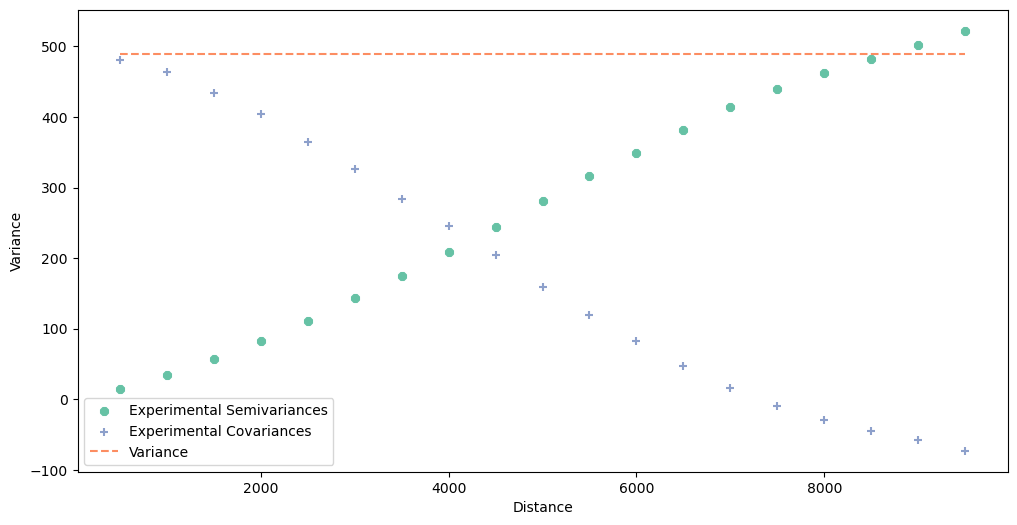

In [7]:
experimental_variogram.plot(plot_semivariance=True, plot_covariance=True, plot_variance=True)

Our plot shows three objects:

1. **Circles** represent *semivariance*,
2. **Plus signs** represent *covariance*,
3. **The dashed line** is a *variance*.

We see here that semivariance and covariance are mirrored. What does it mean? It is normal behavior, and we should expect it - semivariance and covariance have symmetrical trends (they differ in a sign). We can read it as:

- with **semivariance**, the dissimilarity between point pairs over a distance increases,
- **covariance** shows that the similarity between point pairs over a distance decreases.

In the best-case scenario (data is stationary, e.g., mean and variance don't change with a distance), the difference between variance and covariance should be equal to semivariance. That's why our `ExperimentalVariogram` object prints the difference between those two. We can quickly check if the process we measure is stationary.

With the experimental variogram, we can create a theoretical model of semivariance.

## 3. Set manually different semivariogram models

With an experimental variogram, we can start modeling theoretical function that optimally describes observed data. Our role is to choose the modeling function and to set three hyperparameters: nugget, sill, and range. You can read more about semivariogram models here: [Geostatistics: Theoretical Variogram Models](https://ml-gis-service.com/index.php/2022/04/01/geostatistics-theoretical-variogram-models/).

Semivariogram has three basic properties:

- **nugget**: the initial value at a zero distance, in most cases, it is zero, but sometimes it represents a bias in observations.
- **sill**: the point where semivariogram flattens and reaches approximately 95% of dissimilarity. Sometimes we cannot find a sill; for example, if differences grow exponentially, but in `pyinterpolate` it is usually set close to the variance of data,
- **range**: is a distance where a variogram reaches its sill. Larger distances are negligible for interpolation.

We are not forced to know all of them at the beginning. **Range** and **sill** may be easily computed by the algorithm. The nugget is slightly different. As a programmer, I can tell you that it is easy to build an algorithm for nugget grid search, and it will work the same as for range & sill. But nugget may represent systematic bias, and we should be sure that it is different than zero if we use it. The algorithm doesn't know about our sampling method!

A theoretical model can be created in two ways:
1. Manually, with the `build_theoretical_variogram()` function,
2. Semi-automatically, but here's the catch: we must create a `TheoreticalVariogram` object first, and in the second step, we may use the `.autofit()` method of this class. Why is that? The reason is simple - if we want to fit semivariogram automatically, then the algorithm (or creator) assumes that we know what we are doing.

We start from the `build_theoretical_variogram()` function and look into different models fitted to our data.

### Models:

* circular,
* cubic,
* exponential,
* gaussian,
* linear,
* power,
* spherical.

We will set:

- **sill** to the experimental variogram variance,
- **nugget** to zero,
- **range** to 8000 (we see in the experimental variogram plot that around this range semivariance *flattens*, and it is close to the variance).

In [8]:
sill = experimental_variogram.variance
nugget = 0
var_range = 8000

In [9]:
# circular

circular_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                             model_type='circular',
                                             sill=sill,
                                             rang=var_range,
                                             nugget=nugget)

In [10]:
print(circular_model)

* Selected model: Circular model
* Nugget: 0
* Sill: 489.8203263077297
* Range: 8000
* Spatial Dependency Strength is Unknown
* Mean Bias: -52.60629816538766
* Mean RMSE: 63.00280857591537
* Error-lag weighting method: None


+--------+--------------------+--------------------+---------------------+
|  lag   |    theoretical     |    experimental    |     bias (y-y')     |
+--------+--------------------+--------------------+---------------------+
| 500.0  | 38.95327145564127  | 14.716058620972868 | -24.237212834668405 |
| 1000.0 | 77.75383379923632  | 34.85400868491261  |  -42.89982511432371 |
| 1500.0 | 116.24715805742854 | 57.712760007769795 |  -58.53439804965874 |
| 2000.0 | 154.2749647378938  | 82.49483539006093  |  -71.78012934783288 |
| 2500.0 | 191.6730553536057  | 111.4449493651956  |  -80.22810598841009 |
| 3000.0 | 228.26874220429443 | 143.4007980025356  |  -84.86794420175883 |
| 3500.0 | 263.87764398483665 | 175.10704725708965 |   -88.770596727747  |
| 4000.0 | 298.299491831

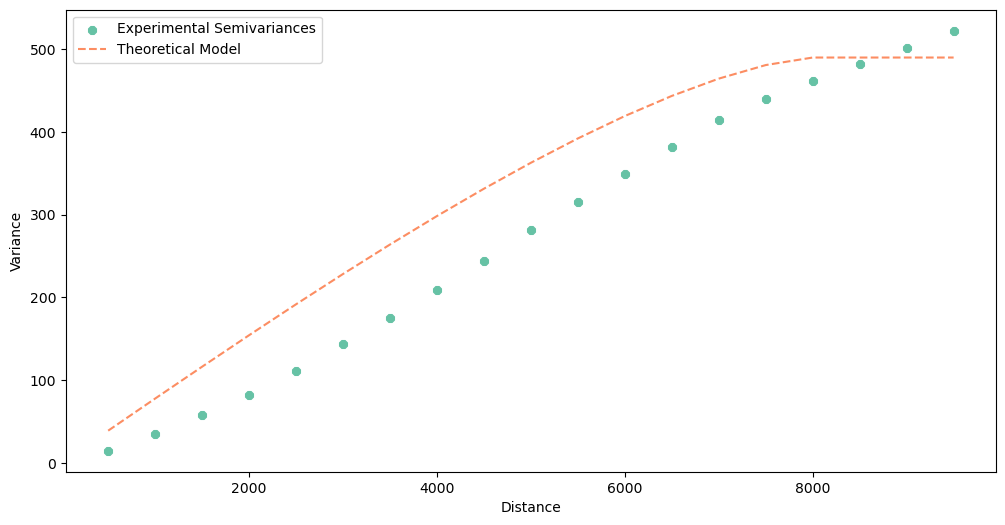

In [11]:
circular_model.plot(experimental=True)

In [12]:
# cubic

cubic_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                          model_type='cubic',
                                          sill=sill,
                                          rang=var_range,
                                          nugget=nugget)

In [13]:
print(cubic_model)

* Selected model: Cubic model
* Nugget: 0
* Sill: 489.8203263077297
* Range: 8000
* Spatial Dependency Strength is Unknown
* Mean Bias: -77.44307814715333
* Mean RMSE: 100.93081804872125
* Error-lag weighting method: None


+--------+--------------------+--------------------+---------------------+
|  lag   |    theoretical     |    experimental    |     bias (y-y')     |
+--------+--------------------+--------------------+---------------------+
| 500.0  | 12.34878902539015  | 14.716058620972868 |  2.3672695955827177 |
| 1000.0 | 45.255288629599086 | 34.85400868491261  | -10.401279944686479 |
| 1500.0 | 92.68405535286398  | 57.712760007769795 | -34.971295345094184 |
| 2000.0 | 148.9805383955685  | 82.49483539006093  |  -66.48570300550756 |
| 2500.0 | 209.04428231682044 | 111.4449493651956  |  -97.59933295162485 |
| 3000.0 | 268.48143737523486 | 143.4007980025356  | -125.08063937269927 |
| 3500.0 | 323.7296800593239  | 175.10704725708965 | -148.62263280223428 |
| 4000.0 | 372.14864635489

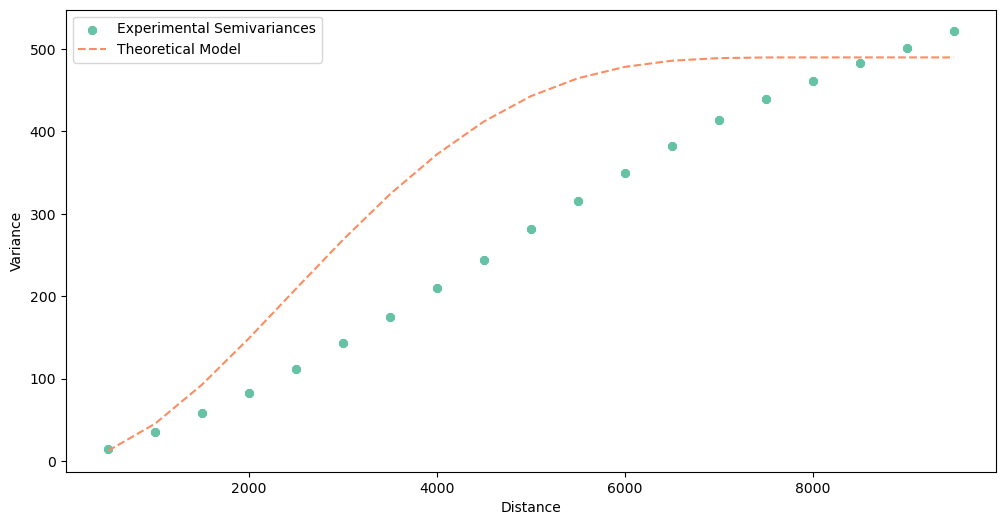

In [14]:
cubic_model.plot()

In [15]:
# Exponential model

exponential_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                                model_type='exponential',
                                                sill=sill,
                                                rang=var_range,
                                                nugget=nugget)
print(exponential_model)

* Selected model: Exponential model
* Nugget: 0
* Sill: 489.8203263077297
* Range: 8000
* Spatial Dependency Strength is Unknown
* Mean Bias: 62.87847144716388
* Mean RMSE: 97.41020702761479
* Error-lag weighting method: None


+--------+--------------------+--------------------+---------------------+
|  lag   |    theoretical     |    experimental    |     bias (y-y')     |
+--------+--------------------+--------------------+---------------------+
| 500.0  | 29.676713342689204 | 14.716058620972868 | -14.960654721716336 |
| 1000.0 | 57.555405518182404 | 34.85400868491261  | -22.701396833269797 |
| 1500.0 | 83.74501312199658  | 57.712760007769795 | -26.032253114226783 |
| 2000.0 | 108.34787261497875 | 82.49483539006093  | -25.853037224917827 |
| 2500.0 | 131.46012020525072 | 111.4449493651956  |  -20.01517084005512 |
| 3000.0 | 153.17206750253146 | 143.4007980025356  |  -9.771269499995867 |
| 3500.0 | 173.56855441271478 | 175.10704725708965 |  1.538492844374872  |
| 4000.0 | 192.7292806

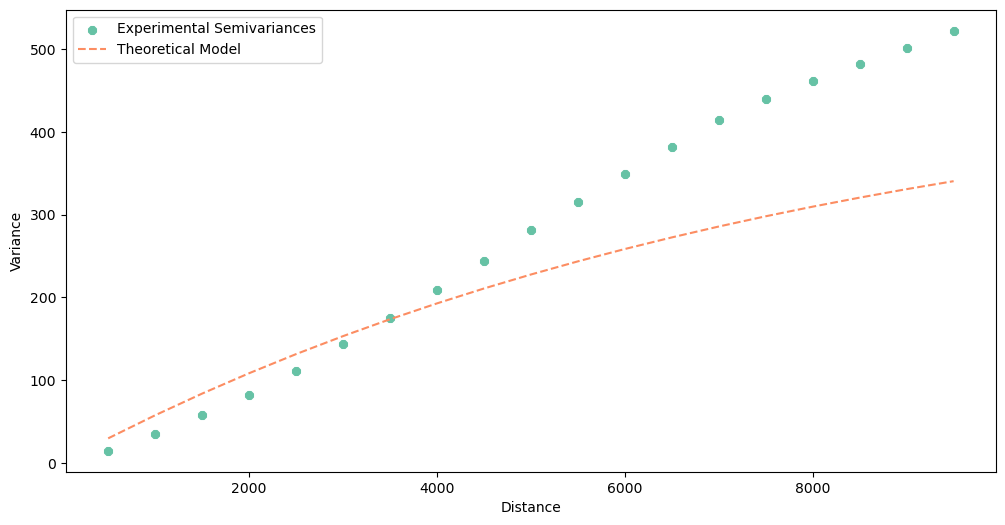

In [16]:
exponential_model.plot()

In [17]:
# Gaussian model

gaussian_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                             model_type='gaussian',
                                             sill=sill,
                                             rang=var_range,
                                             nugget=nugget)
print(gaussian_model)

* Selected model: Gaussian model
* Nugget: 0
* Sill: 489.8203263077297
* Range: 8000
* Spatial Dependency Strength is Unknown
* Mean Bias: 106.76795548020137
* Mean RMSE: 116.3487709038113
* Error-lag weighting method: None


+--------+--------------------+--------------------+--------------------+
|  lag   |    theoretical     |    experimental    |    bias (y-y')     |
+--------+--------------------+--------------------+--------------------+
| 500.0  | 1.9096284783003161 | 14.716058620972868 | 12.806430142672552 |
| 1000.0 | 7.593960284943274  | 34.85400868491261  | 27.26004839996933  |
| 1500.0 | 16.92106251490172  | 57.712760007769795 | 40.791697492868074 |
| 2000.0 | 29.676713342689204 | 82.49483539006093  | 52.81812204737172  |
| 2500.0 | 45.57258050587133  | 111.4449493651956  | 65.87236885932427  |
| 3000.0 | 64.25705194799532  | 143.4007980025356  | 79.14374605454027  |
| 3500.0 | 85.32815073541408  | 175.10704725708965 | 89.77889652167556  |
| 4000.0 | 108.34787261497875 | 20

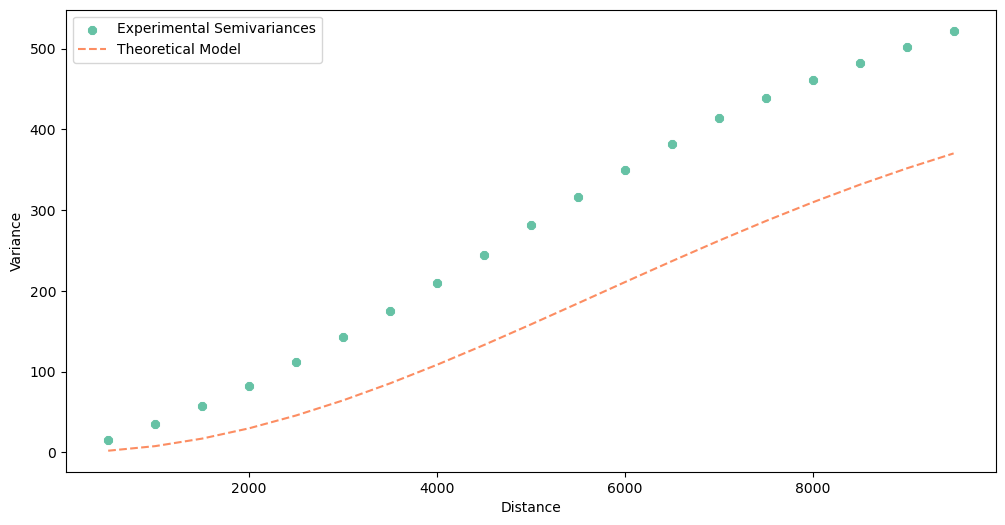

In [18]:
gaussian_model.plot()

In [19]:
# Linear model

linear_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                           model_type='linear',
                                           sill=sill,
                                           rang=var_range,
                                           nugget=nugget)
print(linear_model)

* Selected model: Linear model
* Nugget: 0
* Sill: 489.8203263077297
* Range: 8000
* Spatial Dependency Strength is Unknown
* Mean Bias: -21.58683474038296
* Mean RMSE: 28.218692107535404
* Error-lag weighting method: None


+--------+--------------------+--------------------+---------------------+
|  lag   |    theoretical     |    experimental    |     bias (y-y')     |
+--------+--------------------+--------------------+---------------------+
| 500.0  | 30.613770394233107 | 14.716058620972868 | -15.897711773260239 |
| 1000.0 | 61.227540788466214 | 34.85400868491261  | -26.373532103553607 |
| 1500.0 | 91.84131118269931  | 57.712760007769795 |  -34.12855117492952 |
| 2000.0 | 122.45508157693243 | 82.49483539006093  |  -39.9602461868715  |
| 2500.0 | 153.06885197116554 | 111.4449493651956  | -41.623902605969946 |
| 3000.0 | 183.68262236539863 | 143.4007980025356  | -40.281824362863034 |
| 3500.0 | 214.29639275963174 | 175.10704725708965 | -39.189345502542096 |
| 4000.0 | 244.9101631538

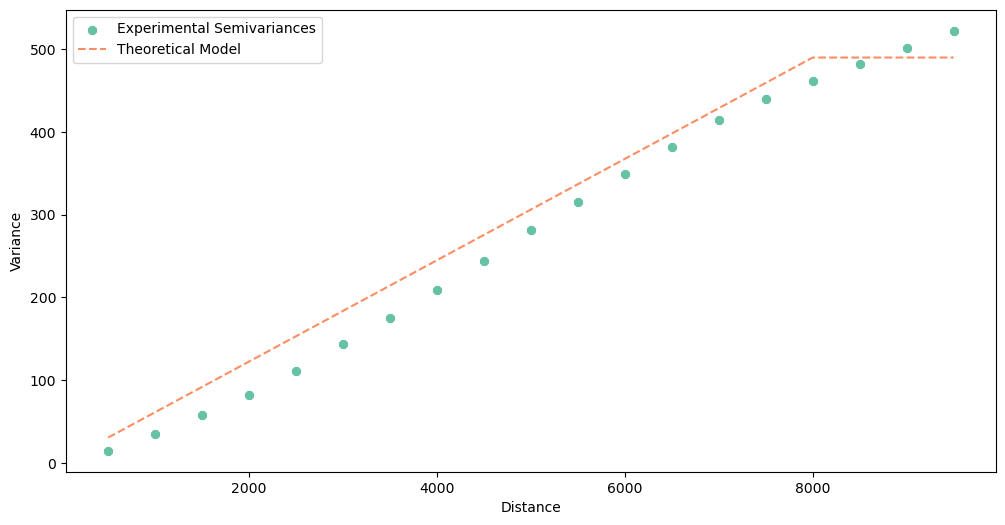

In [20]:
linear_model.plot()

In [21]:
# Power model

power_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                          model_type='power',
                                          sill=sill,
                                          rang=var_range,
                                          nugget=nugget)
print(power_model)

* Selected model: Power model
* Nugget: 0
* Sill: 489.8203263077297
* Range: 8000
* Spatial Dependency Strength is Unknown
* Mean Bias: 46.89133587829636
* Mean RMSE: 58.334699200244835
* Error-lag weighting method: None


+--------+--------------------+--------------------+--------------------+
|  lag   |    theoretical     |    experimental    |    bias (y-y')     |
+--------+--------------------+--------------------+--------------------+
| 500.0  | 1.9133606496395692 | 14.716058620972868 | 12.802697971333298 |
| 1000.0 | 7.653442598558277  | 34.85400868491261  | 27.20056608635433  |
| 1500.0 | 17.22024584675612  | 57.712760007769795 | 40.49251416101367  |
| 2000.0 | 30.613770394233107 | 82.49483539006093  | 51.88106499582782  |
| 2500.0 | 47.83401624098923  | 111.4449493651956  | 63.61093312420637  |
| 3000.0 | 68.88098338702449  | 143.4007980025356  | 74.51981461551111  |
| 3500.0 | 93.75467183233889  | 175.10704725708965 | 81.35237542475076  |
| 4000.0 | 122.45508157693243 | 209.3

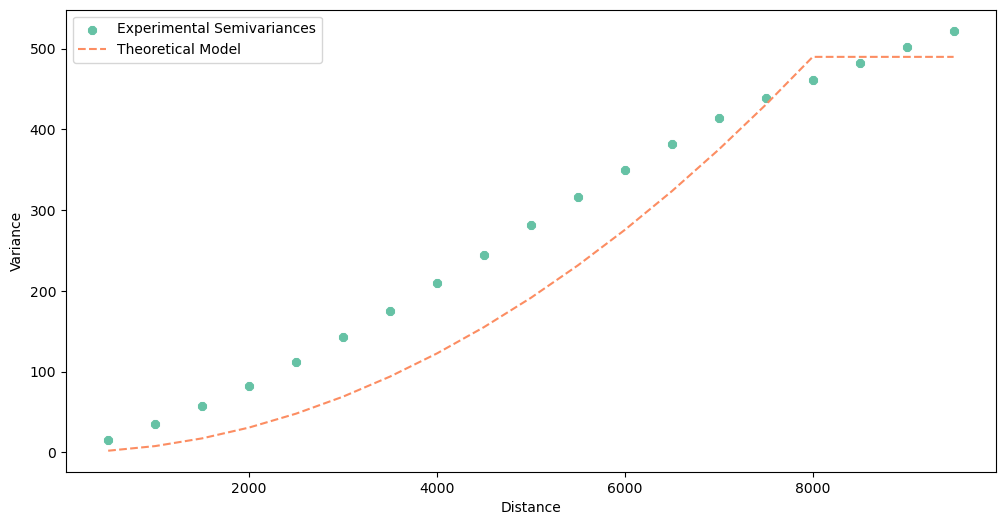

In [22]:
power_model.plot()

In [23]:
# Spherical model

spherical_model = build_theoretical_variogram(experimental_variogram=experimental_variogram,
                                              model_type='spherical',
                                              sill=sill,
                                              rang=var_range,
                                              nugget=nugget)

print(spherical_model)

* Selected model: Spherical model
* Nugget: 0
* Sill: 489.8203263077297
* Range: 8000
* Spatial Dependency Strength is Unknown
* Mean Bias: -72.94546270439245
* Mean RMSE: 87.44243944688779
* Error-lag weighting method: None


+--------+--------------------+--------------------+---------------------+
|  lag   |    theoretical     |    experimental    |     bias (y-y')     |
+--------+--------------------+--------------------+---------------------+
| 500.0  | 45.86086307104843  | 14.716058620972868 |  -31.14480445007556 |
| 1000.0 | 91.36297102028944  | 34.85400868491261  |  -56.50896233537683 |
| 1500.0 | 136.1475687259156  | 57.712760007769795 |  -78.4348087181458  |
| 2000.0 | 179.85590106611951 | 82.49483539006093  |  -97.36106567605859 |
| 2500.0 | 222.12921291909373 | 111.4449493651956  | -110.68426355389813 |
| 3000.0 | 262.6087491630309  | 143.4007980025356  |  -119.2079511604953 |
| 3500.0 | 300.9357546761235  | 175.10704725708965 | -125.82870741903386 |
| 4000.0 | 336.75147433

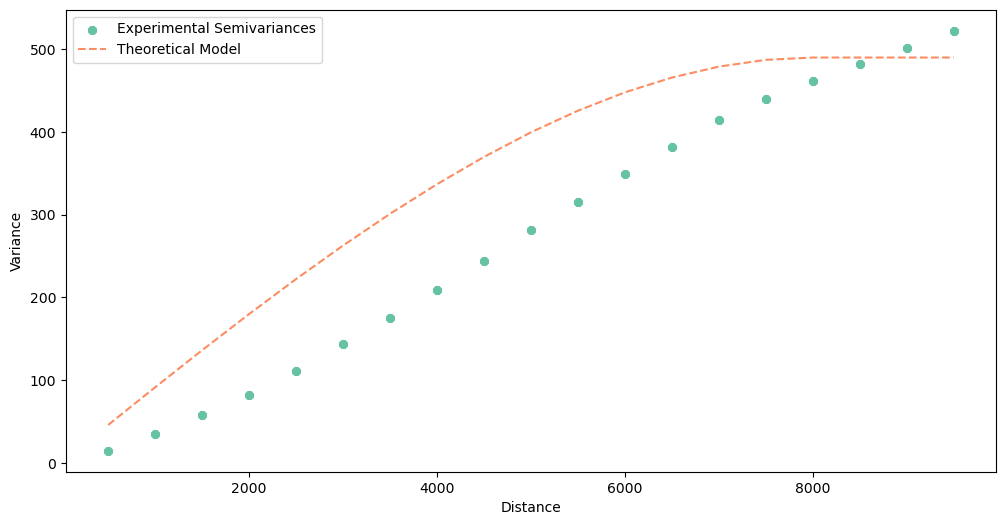

In [24]:
spherical_model.plot()

Quick look into plots, and we can bet that the best model is **linear**. We can read each table printed with a `print()` method, but instead, we will read *Root Mean Squared Error* of each model and select the model with the lowest value of RMSE:

In [25]:
models = [
    circular_model, cubic_model, exponential_model, gaussian_model, linear_model, power_model, spherical_model
]

lowest_rmse = np.inf
chosen_model = ''

for _model in models:
    
    # Get attrs
    model_name = _model.name
    model_rmse = _model.rmse
    
    # Check error
    if model_rmse < lowest_rmse:
        lowest_rmse = model_rmse
        chosen_model = model_name
    
    # Print status
    msg = f'Model: {model_name}, RMSE: {model_rmse}'
    print(msg)
    print('')

msg = f'The best model is {chosen_model} with RMSE {lowest_rmse}'
print(msg)

Model: circular, RMSE: 63.00280857591537

Model: cubic, RMSE: 100.93081804872125

Model: exponential, RMSE: 97.41020702761479

Model: gaussian, RMSE: 116.3487709038113

Model: linear, RMSE: 28.218692107535404

Model: power, RMSE: 58.334699200244835

Model: spherical, RMSE: 87.44243944688779

The best model is linear with RMSE 28.218692107535404


## 4) Set automatically semivariogram model

We can set the semivariogram model automatically, but we can’t do it with the `build_theoretical_variogram()` function. Instead we use `TheoreticalVariogram` class - object of this type is generated by `build_theoretical_variogram()` function.

This process has two steps:

1. Initilize the `TheoreticalVariogram` class object.
2. Let the algorithm fit the best model, then find the optimal range and sill with the `.autofit()` method.

The `autofit()` method takes multiple parameters, the most important for us are:

- `experimental_variogram` - the experimental variogram (`ExperimentalVariogram` type), 
- `model_types` - list of models of string with a model name. Available models:
    - all - the same as list with all models,
    - circular,
    - cubic,
    - exponential,
    - gaussian,
    - linear,
    - power,
    - spherical.
- `nugget` - **default = 0** - nugget (bias) of a variogram. Default value is 0.
- `rang` - if given, then range is fixed to this value.
- `min_range` - **default = 0.1** - the minimal fraction of a variogram to find an optimal range.
- `max_range` - **default = 0.5** - the maximum fraction of a variogram range to find an optimal range. Parameter set to value greater 0.5 raises warning.
- `number_of_ranges` - **default = 64** - how many equally spaced ranges are tested between `min_range` and `max_range`.
- `sill` - if given, then it is fixed to this value.
- `min_sill` - **default = 0** - the minimal fraction of variogram variance at lag 0 to find a sill.
- `max_sill` - **default = 1** - the maximum fraction of variogram variance at lag 0 to find a sill. It should be lower or equal to 1, but it is possible to set it above. Warning is printed if `max_sill` is greater than 1.
- `number_of_sills` - **default = 64** - how many equally spaced sill values are tested between `min_sill` and `max_sill`.
- `error_estimator` - **default = 'rmse'** - Error estimation to choose the best model. Available options are:
    - rmse: Root Mean Squared Error,
    - mae: Mean Absolute Error,
    - bias: Forecast Bias,
    - smape: Symmetric Mean Absolute Percentage Error.

In the first run, we will set nugget, sill, and range as fixed values, and we will see which model algorithm chooses:

In [26]:
semivariogram_model = TheoreticalVariogram()

In [27]:
fitted = semivariogram_model.autofit(
    experimental_variogram=experimental_variogram,
    model_types='all',
    nugget=0,
    rang=var_range,
    sill=sill)

In [28]:
fitted

{'model_type': 'linear',
 'nugget': 0,
 'sill': 489.8203263077297,
 'range': 8000,
 'fitted_model': array([[ 500.        ,   30.61377039],
        [1000.        ,   61.22754079],
        [1500.        ,   91.84131118],
        [2000.        ,  122.45508158],
        [2500.        ,  153.06885197],
        [3000.        ,  183.68262237],
        [3500.        ,  214.29639276],
        [4000.        ,  244.91016315],
        [4500.        ,  275.52393355],
        [5000.        ,  306.13770394],
        [5500.        ,  336.75147434],
        [6000.        ,  367.36524473],
        [6500.        ,  397.97901513],
        [7000.        ,  428.59278552],
        [7500.        ,  459.20655591],
        [8000.        ,  489.82032631],
        [8500.        ,  489.82032631],
        [9000.        ,  489.82032631],
        [9500.        ,  489.82032631]]),
 'rmse': 28.218692107535404,
 'bias': nan,
 'mae': nan,
 'smape': nan}

The chosen model is **linear**, automatically set as the class parameter. The algorithm performs the same steps as we did before. It has selected a model based on the RMSE. All other parameters were untouched.

Now, we let the algorithm find the optimal sill and range, and we check if our RMSE will be better with a different pair of sill and range:

In [29]:
fitted = semivariogram_model.autofit(experimental_variogram=experimental_variogram, nugget=0)

In [30]:
print(fitted)

{'model_type': 'cubic', 'nugget': 0, 'sill': 489.8203263077297, 'range': 12335.489979757927, 'fitted_model': array([[5.00000000e+02, 5.34805582e+00],
       [1.00000000e+03, 2.02557839e+01],
       [1.50000000e+03, 4.30386760e+01],
       [2.00000000e+03, 7.20566873e+01],
       [2.50000000e+03, 1.05735635e+02],
       [3.00000000e+03, 1.42587601e+02],
       [3.50000000e+03, 1.81229998e+02],
       [4.00000000e+03, 2.20402979e+02],
       [4.50000000e+03, 2.58984845e+02],
       [5.00000000e+03, 2.96005120e+02],
       [5.50000000e+03, 3.30654972e+02],
       [6.00000000e+03, 3.62294630e+02],
       [6.50000000e+03, 3.90457480e+02],
       [7.00000000e+03, 4.14850490e+02],
       [7.50000000e+03, 4.35350655e+02],
       [8.00000000e+03, 4.51997098e+02],
       [8.50000000e+03, 4.64978532e+02],
       [9.00000000e+03, 4.74615706e+02],
       [9.50000000e+03, 4.81338548e+02]]), 'rmse': 15.444756774880005, 'bias': nan, 'mae': nan, 'smape': nan}


After `.autofit()` our algorithm has chosen a different set of parameters and a model type! Let's plot it against experimental variogram:

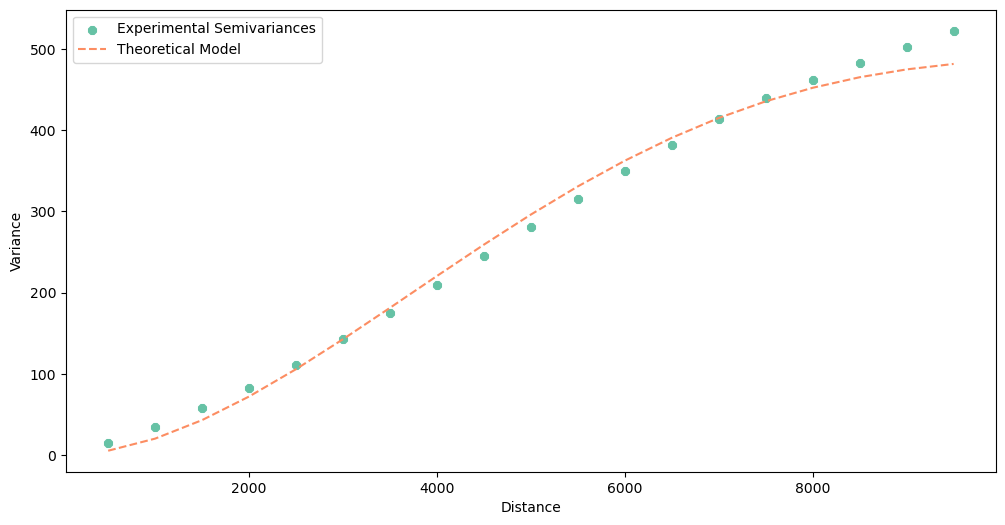

In [31]:
semivariogram_model.plot()

Compare this model to the linear model fitted before:

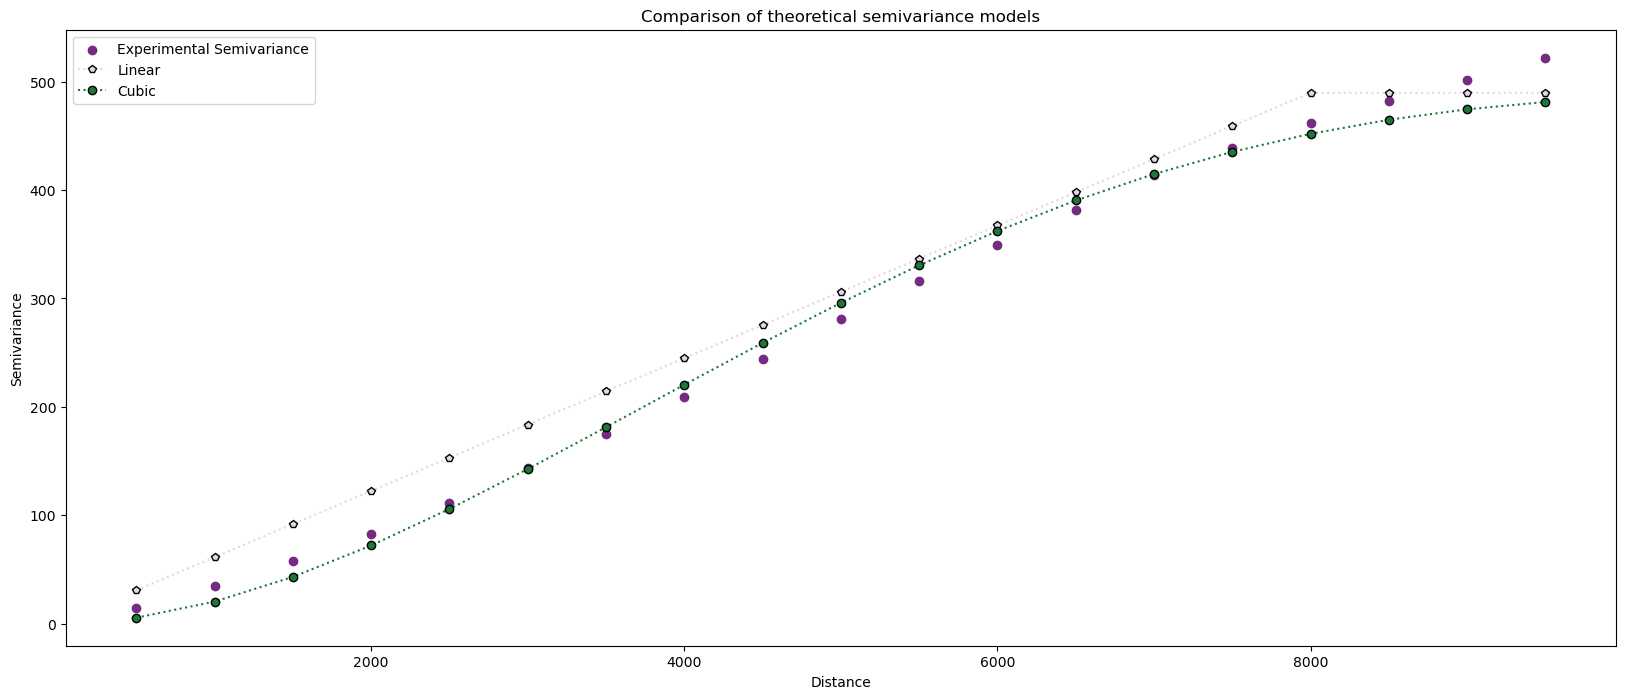

In [32]:
_lags = semivariogram_model.lags

plt.figure(figsize=(20, 8))
plt.scatter(_lags, experimental_variogram.experimental_semivariances, color='#762a83')  # Experimental
plt.plot(_lags, linear_model.fitted_model[:, 1], ':p', color='#e7d4e8', mec='black')
plt.plot(_lags, semivariogram_model.fitted_model[:, 1], ':o', color='#1b7837', mec='black')
plt.title('Comparison of theoretical semivariance models')
plt.legend(['Experimental Semivariance',
            'Linear',
            'Cubic'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

## 5) Export model

Models could be exported and used for other purposes. It is vital for the **semivariogram regularization**. Those calculations are computationally intensive, and in production, it is not a good idea to build a full pipeline; we divide it into two steps.

Model can be exported to `dict` with `.to_dict()` method or to `json` with `.to_json()` method:

In [33]:
# Set spherical model

dict_model = semivariogram_model.to_dict()

# Save to json
semivariogram_model.to_json('output/semivariogram_calculation_model.json')

## 6) Import model

We can import a semivariogram model into a new **TheoreticalSemivariogram** class instance without passing into it experimental semivariogram or actual data points. It is useful for some applications focused on kriging, where we are sure that our semivariogram model fits data well.

We can import a model with two methods `.from_dict()` if we have our model parameters in Python dictionary or `.from_json()` if model parameters are stored in a flat file:

In [34]:
other_model_from_dict = TheoreticalVariogram()

print(other_model_from_dict)

Theoretical model is not calculated yet. Use fit() or autofit() methods to build or find a model or import model with from_dict() or from_json() methods.


In [35]:
other_model_from_dict.from_dict(dict_model)
print(other_model_from_dict)

* Selected model: Cubic model
* Nugget: 0.0
* Sill: 489.8203263077297
* Range: 12335.489979757927
* Spatial Dependency Strength is Unknown
* Mean Bias: 0.0
* Mean RMSE: 0.0
* Error-lag weighting method: None




In [36]:
other_model_from_json = TheoreticalVariogram()
print(other_model_from_json)

Theoretical model is not calculated yet. Use fit() or autofit() methods to build or find a model or import model with from_dict() or from_json() methods.


In [37]:
other_model_from_json.from_json('output/semivariogram_calculation_model.json')

In [38]:
print(other_model_from_json)

* Selected model: Cubic model
* Nugget: 0.0
* Sill: 489.8203263077297
* Range: 12335.489979757927
* Spatial Dependency Strength is Unknown
* Mean Bias: 0.0
* Mean RMSE: 0.0
* Error-lag weighting method: None




---